# **Variational Auto-Encoder**

In [1]:
import gc
import psutil
import multiprocessing as mp
import copy
mp.cpu_count()
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras import Input,Sequential, initializers, optimizers, callbacks, layers, models
from keras.models import Model,Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Lambda,Activation,Input,Flatten,Reshape,Conv2DTranspose
import keras.backend as K
from keras.layers.merge import add
from sklearn.model_selection import train_test_split
import os
import glob
from time import time,asctime
from random import randint as r
import random

Using TensorFlow backend.


In [2]:
imgs = glob.glob("../input/celeba-dataset/img_align_celeba/img_align_celeba/*.jpg")
imgs[0]

'../input/celeba-dataset/img_align_celeba/img_align_celeba/083648.jpg'

In [3]:
train_y = []
train_y2 = []
for _ in range(0,100000):
  if _%20000 == 0:
    print("{} / 100000".format(_))
  img = cv2.imread(imgs[_])
  img = cv2.resize(img,(32,32))
  train_y.append(img.astype("float32")/255.0)
for _ in range(100000,200000):
  if _%20000 == 0:
    print("{} / 200000".format(_))
  img = cv2.imread(imgs[_])
  img = cv2.resize(img,(32,32))
  train_y2.append(img.astype("float32")/255.0)
train_y = np.array(train_y)
train_y2 = np.array(train_y2)
Y_data = np.vstack((train_y,train_y2))
print(psutil.virtual_memory())
del train_y,train_y2
gc.collect()
print(psutil.virtual_memory())

0 / 100000
20000 / 100000
40000 / 100000
60000 / 100000
80000 / 100000
100000 / 200000
120000 / 200000
140000 / 200000
160000 / 200000
180000 / 200000
svmem(total=16784248832, available=8471912448, percent=49.5, used=7965327360, free=558374912, active=3152592896, inactive=12059430912, buffers=1107968000, cached=7152578560, shared=1339392, slab=864911360)
svmem(total=16784248832, available=10921766912, percent=34.9, used=5515472896, free=3008229376, active=3152592896, inactive=9601953792, buffers=1107968000, cached=7152578560, shared=1339392, slab=864911360)


In [4]:
test_Y = []
for _ in range(200000,202599):
    if _%2000 == 0:
        print("{} / 202599".format(_))
    img = cv2.imread(imgs[_])
    img = cv2.resize(img,(32,32))
    test_Y.append(img.astype("float32")/255.0)
test_Y = np.array(test_Y)

200000 / 202599
202000 / 202599


In [5]:
def sample_z(layers):
    std_norm = K.random_normal(shape=(K.shape(layers[0])[0], latent_dim), mean=0, stddev=1)
    return layers[0] + layers[1]*std_norm

# Encoder part

In [6]:
latent_dim = 50
total_epoch = 50
batch_size = 32
img_dim = (32, 32)

encoder_inputs = keras.Input(shape=(*img_dim, 3))

x = layers.Conv2D(32, kernel_size=(5,5), padding='SAME')(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(32, kernel_size=(5,5), strides=(2,2),padding='SAME')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(64, kernel_size=(5,5), strides=(2,2),padding='SAME')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(64, kernel_size=(5,5), strides=(1,1), padding='SAME')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128, kernel_size=(5,5), strides=(1,1), padding='SAME')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)

x = layers.Dense(64, activation="relu")(x)

mu = layers.Dense(latent_dim)(x)
log_sigma = layers.Dense(latent_dim)(x)

z = layers.Lambda(sample_z)([mu, log_sigma])

encoder = keras.Model(encoder_inputs,z)

encoder.summary()


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
_____________________________________

# Decoder part

In [7]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 128))(x)

x = layers.Conv2D(128, kernel_size=(5,5), strides=(1,1), padding='SAME')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, kernel_size=(5,5),strides=(1,1), padding='SAME')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=(5,5),strides=(2,2), padding='SAME')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, kernel_size=(5,5),strides=(2,2),padding='SAME')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, kernel_size=(5,5), padding='SAME')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8192)              417792    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         409728    
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 64)          204864    
__________

# LOSS FUNCTIONS

In [8]:
def reconstruction_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

def kl_loss(y_true, y_pred):
    kl_loss = K.abs(keras.losses.KLD(y_true, y_pred))
    return kl_loss

def vae_loss(y_true, y_pred):
    return reconstruction_loss(y_true, y_pred)+0.25*kl_loss(y_true, y_pred)

# Connecting the Encoder and Decoder to make the **Auto Encoder**

In [9]:
vae = keras.Model(encoder_inputs, decoder(encoder(encoder_inputs)))

In [10]:
vae.compile(optimizer = "adam",loss = vae_loss,metrics = [kl_loss,reconstruction_loss])

# Training the VAE

In [11]:
vae.fit(Y_data,Y_data,batch_size = 32,epochs = total_epoch)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
200000/200000 [==============================] - 124s 621us/step - loss: 0.0963 - kl_loss: 0.2672 - reconstruction_loss: 0.0295
Epoch 2/50
200000/200000 [==============================] - 119s 597us/step - loss: 0.0803 - kl_loss: 0.2320 - reconstruction_loss: 0.0223
Epoch 3/50
200000/200000 [==============================] - 119s 596us/step - loss: 0.0746 - kl_loss: 0.2191 - reconstruction_loss: 0.0199
Epoch 4/50
200000/200000 [==============================] - 120s 598us/step - loss: 0.0708 - kl_loss: 0.2094 - reconstruction_loss: 0.0185
Epoch 5/50
200000/200000 [==============================] - 120s 598us/step - loss: 0.0688 - kl_loss: 0.2040 - reconstruction_loss: 0.0178
Epoch 6/50
200000/200000 [==============================] - 119s 597us/step - loss: 0.0675 - kl_loss: 0.2006 - reconstruction_loss: 0.0173
Epoch 7/50
200000/200000 [==============================] - 119s 596us/step - loss: 0.0663 - kl_loss: 0.1975 - reconst

# Displaying result

In [12]:
pred = vae.predict(test_Y)

974


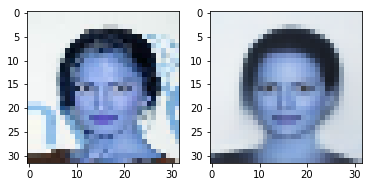

In [31]:
temp = r(0,2599)
print(temp)
plt.subplot(1,2,1)
plt.imshow(test_Y[temp])
plt.subplot(1,2,2)
plt.imshow(pred[temp])

Generating a new face by passing a random normal sample of size (32,32,3) and observing the output

1499


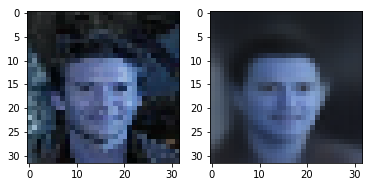

In [59]:
temp = r(0,2599)
print(temp)
plt.subplot(1,2,1)
plt.imshow(test_Y[temp])
plt.subplot(1,2,2)
plt.imshow(pred[temp])